In [236]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

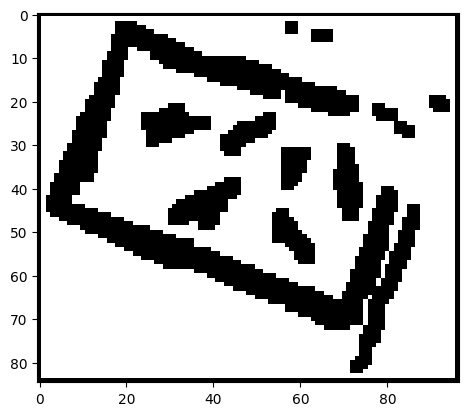

In [237]:
bitmap = np.load('map.npy')
plt.imshow(bitmap.transpose(), cmap='gray')

def is_intersected(p1, p2) -> bool:
    
    line = np.linspace(p1, p2, endpoint=True)
    return False in [bitmap[*np.round(point).astype(int)] for point in line]

def display(graph):
    plt.figure(figsize=(10, 10))
    plt.imshow(bitmap.transpose(), cmap='gray', aspect='equal')
    nx.draw(graph, pos, node_size=2, width=0.5)
    plt.axis('on')
    plt.gca().tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xlim(0, bitmap.shape[0]-1)
    plt.ylim(bitmap.shape[1]-1, 0)

Graph creation

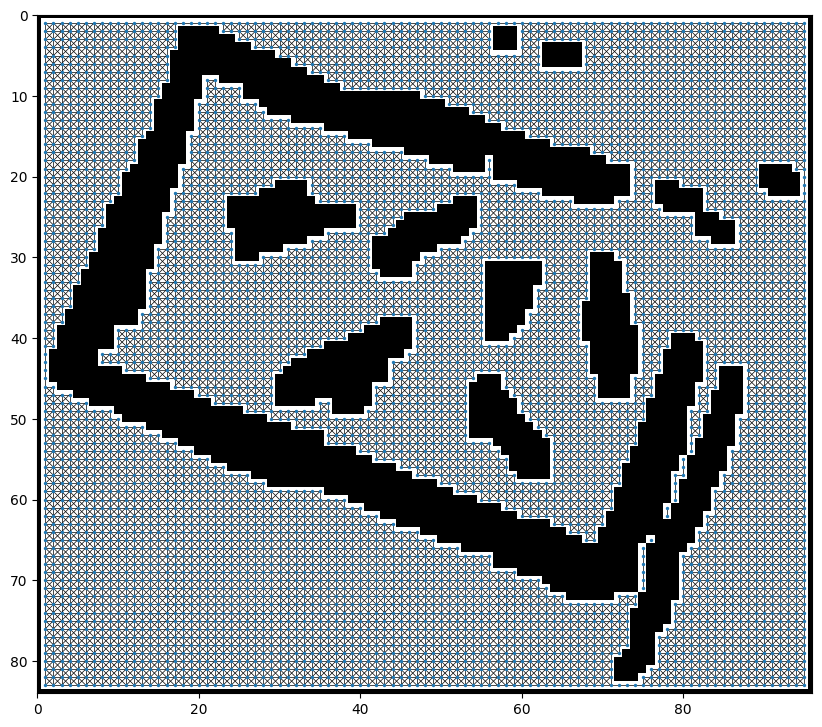

In [238]:
xs, ys = np.array(range(bitmap.shape[0])), np.array(range(bitmap.shape[1]))
cells = np.stack(np.meshgrid(xs, ys), axis=2)
free_cells = cells[bitmap.transpose()].reshape((-1, 2))

graph = nx.Graph()
graph.add_nodes_from([tuple(coord) for coord in free_cells])
pos = {tuple(coord) : coord for coord in free_cells}


for node in graph.nodes:
    coord = np.array(node)
    for move in ((0, 1), (1, 0), (1, 1), (1, -1)):
        neighbour = tuple(coord + np.array(move))
        if neighbour not in graph.nodes:
            continue
        checks = {(1, 1) : [coord+np.array([1, 0]), coord+np.array([0, 1])],
                  (1,-1) : [coord+np.array([0, -1]), coord+np.array([1, 0])]}
        if move in checks:
            if not all([tuple(block) in graph.nodes for block in checks[move]]):
                continue
        graph.add_edge(node, neighbour, weight=norm(np.array(move)))

display(graph)

Visibility graph

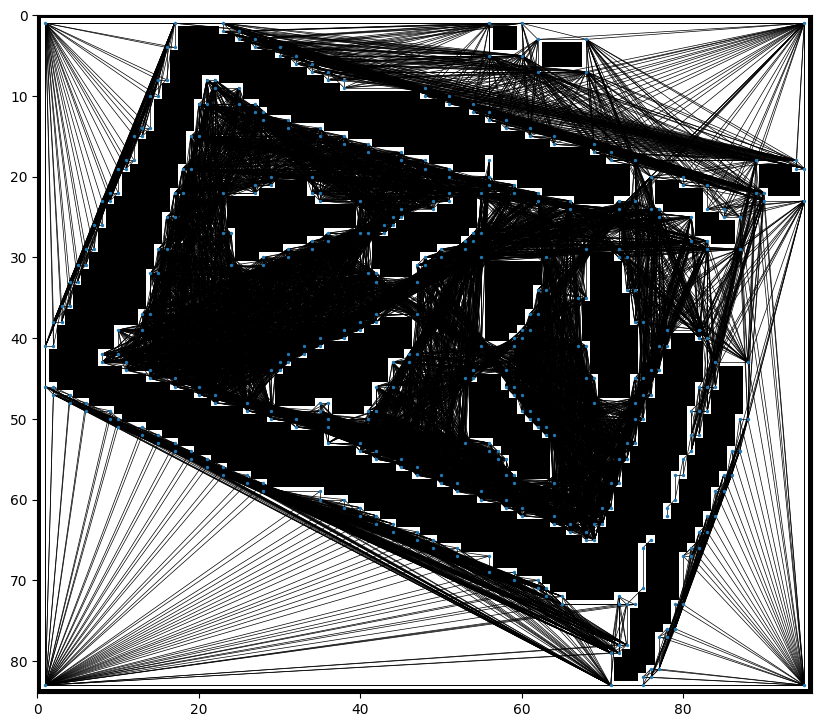

In [239]:
xs, ys = np.array(range(bitmap.shape[0]-1)), np.array(range(bitmap.shape[1]-1)), 
cells = np.stack(np.meshgrid(xs, ys), axis=2).reshape((-1, 2))
graph = nx.Graph()

for cell in cells:
    x, y = cell
    area = [*bitmap[x:x+2, y:y+2].reshape(-1)]
    count = area.count(False)
    if count % 2:
        i = 3-area.index(False) if count == 1 else area.index(True)
        graph.add_node((x + i//2, y + i%2))
        
pos = {node : np.array(node) for node in graph}

for i, first in enumerate(graph.nodes):
    for second in list(graph.nodes)[i+1:]:
        if not is_intersected(pos[first], pos[second]):
            graph.add_edge(first, second, weight=norm(pos[first]-pos[second]))

display(graph)

Voronoi

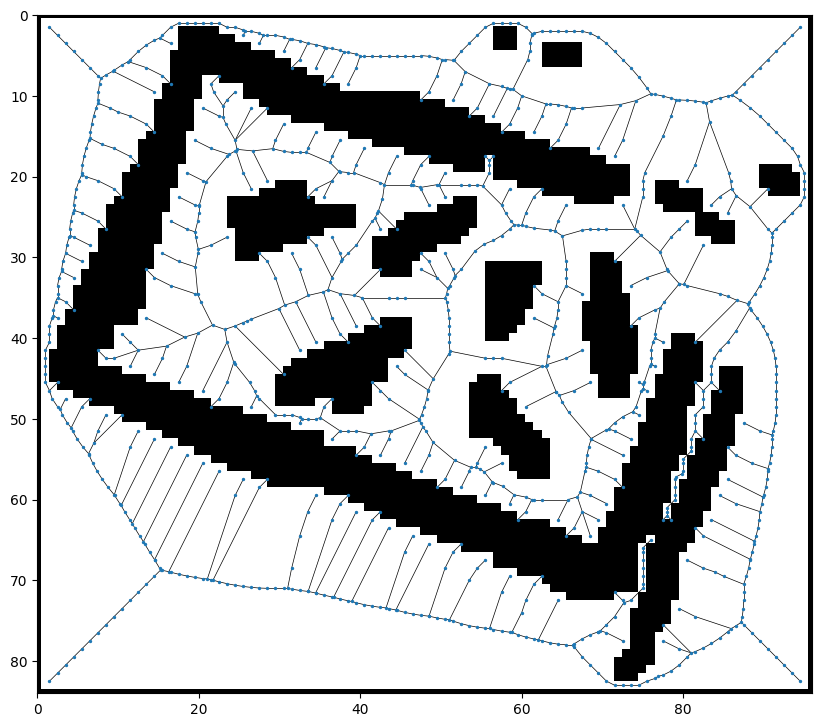

In [240]:
from scipy.spatial import Voronoi

xs, ys = np.array(range(bitmap.shape[0])), np.array(range(bitmap.shape[1])), 
cells = np.stack(np.meshgrid(xs, ys), axis=2)
obstacles = cells[~bitmap.transpose()].reshape((-1, 2))

diagram = Voronoi(obstacles)
pos = {i : coord for i, coord in enumerate(diagram.vertices)}
graph = nx.Graph()
graph.add_nodes_from(pos)
graph.add_node(-1)
graph.add_edges_from(diagram.ridge_vertices)
graph.remove_node(-1)

for node in pos:
    try:
        if not bitmap[*np.round(pos[node]).astype(int)]:
            graph.remove_node(node)
    except IndexError:
        graph.remove_node(node)
        
nx.set_edge_attributes(graph, {(start, end) : norm(pos[start]-pos[end]) for start, end in graph.edges}, 'weight')

display(graph)

In [253]:
START = tuple(np.array(graph.nodes)[np.random.randint(0, len(graph.nodes)-1)])
FINISH = tuple(np.array(graph.nodes)[np.random.randint(0, len(graph.nodes)-1)])

Dijkstra

START: 196
FINISH: 1257


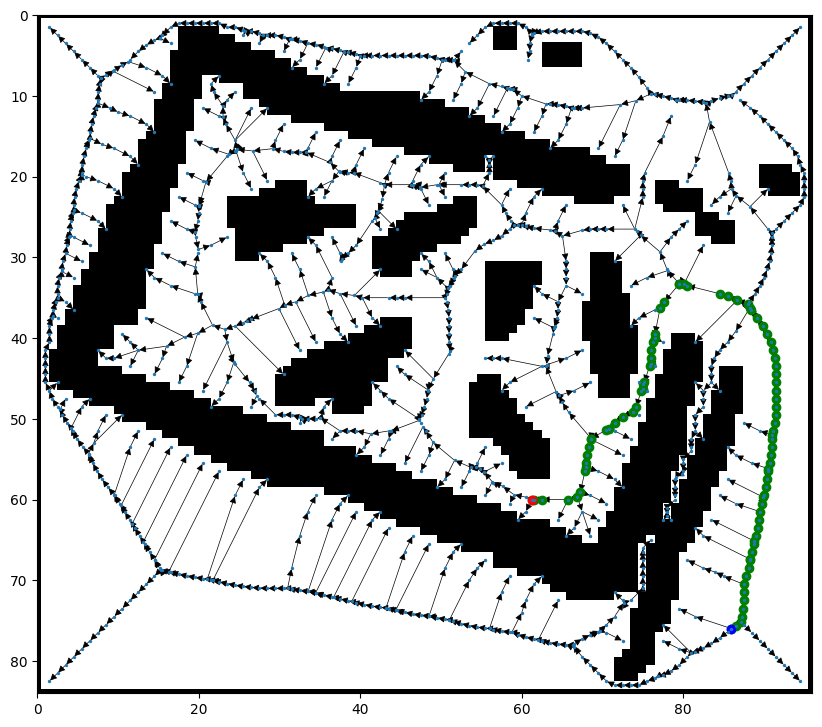

In [254]:
print(f'START: {START}\nFINISH: {FINISH}')
nx.set_node_attributes(graph, np.inf, 'weight')
nx.set_node_attributes(graph, {START : 0.}, 'weight')
G = nx.DiGraph()
G.add_node(START)

visited = set()
current_node = START
while True:
    for n in graph.neighbors(current_node):
        if n in visited:
            continue
        possible_path = graph.nodes[current_node]['weight'] + graph.edges[n, current_node]['weight']
        if graph.nodes[n]['weight'] > possible_path:
            if n in G:
                G.remove_node(n)
            G.add_edge(current_node, n)
            nx.set_node_attributes(graph, {n : possible_path}, 'weight')
    
    visited.add(current_node)
    close_nodes = {node for node in graph.nodes if graph.nodes[node]['weight'] < np.inf} - visited
    if not close_nodes:
        break
    current_node = min(close_nodes, key = lambda node: graph.nodes[node]['weight'])
    
path = [FINISH]
while path[-1] != START:
    path.append(*G.predecessors(path[-1]))
path = np.array([pos[node] for node in path]).transpose()
    

display(G)
plt.scatter(*path, c='g')
plt.scatter(*pos[START], c='b')
plt.scatter(*pos[FINISH], c='r')

A*

START: 196
FINISH: 1257


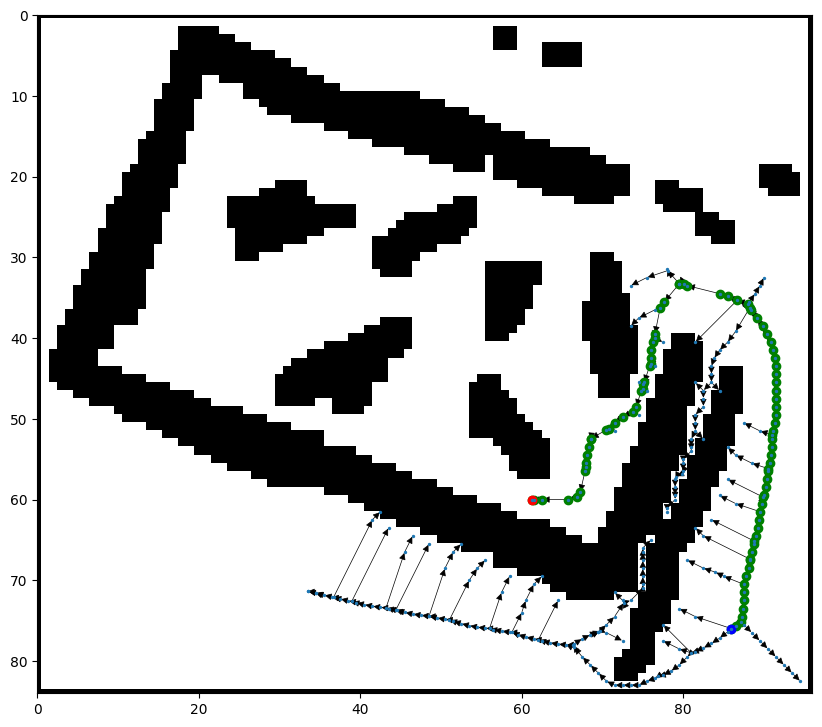

In [255]:
print(f'START: {START}\nFINISH: {FINISH}')
nx.set_node_attributes(graph, {node : norm(pos[FINISH]-pos[node]) for node in graph.nodes}, 'weight')
nx.set_node_attributes(graph, np.inf, 'path')
nx.set_node_attributes(graph, {START : 0.}, 'path')
nx.set_node_attributes(graph, {START : graph.nodes[START]['weight']}, 'cost')

front: dict[tuple, tuple | None] = {START : None}
visited = {}

while True:
    new_node = min(front, key = lambda node: graph.nodes[node]['cost'])
    visited[new_node] = front[new_node]
    front.pop(new_node)
    
    if new_node == FINISH:
        break
    
    for n in graph.neighbors(new_node):
        if n in visited:
            continue
        if graph.nodes[new_node]['path'] + graph.edges[n, new_node]['weight'] < graph.nodes[n]['path'] or n not in front:
            nx.set_node_attributes(graph, {n : graph.nodes[new_node]['path'] + graph.edges[n, new_node]['weight']}, 'path')
            nx.set_node_attributes(graph, {n : graph.nodes[n]['path'] + graph.nodes[n]['weight']}, 'cost')
            front[n] = new_node

path = [FINISH]
while path[-1]:
    path.append(visited[path[-1]])
path = np.array([pos[node] for node in path[:-1]]).transpose()

G = nx.from_dict_of_lists({key : [value] for key, value in visited.items() if value is not None}, nx.DiGraph).reverse()

display(G)
plt.scatter(*path, c='g')
plt.scatter(*pos[START], c='b')
plt.scatter(*pos[FINISH], c='r')